# Kaggle Housing Prices Prediction Notebook

### Import Libraries

In [1551]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA

In [1552]:
train_data = pd.read_csv('train.csv')
train_data = train_data.drop('Id', axis=1)

test_data = pd.read_csv('test.csv')
test_data = test_data.drop('Id', axis=1)

In [1553]:
train_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [1554]:
test_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## Data Preprocessing

### Merge data to preprocess

**Here, we are merging the test and training data to enable us to modify both datasets at once.
We differentiate between the data by assigning a new column called 'ind' which labels the data as test or train.
After we preprocess the data, we will split the data back up again.**

In [1555]:
merged_data = pd.concat([test_data.assign(ind="test"), train_data.assign(ind="train")])
merged_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ind,SalePrice
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,test,NaN
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,test,NaN
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,test,NaN
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,6,2010,WD,Normal,test,NaN
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,NaN,NaN,NaN,0,1,2010,WD,Normal,test,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,8,2007,WD,Normal,train,175000.0
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,MnPrv,NaN,0,2,2010,WD,Normal,train,210000.0
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,train,266500.0
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,4,2010,WD,Normal,train,142125.0


In [1556]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

**Here, we are trying to figure out which columns to drop.
The first cut we will make is if the data has >50% of its values missing.**

In [1557]:
# drop columns if they are missing more than 50% of values
def drop_useless_columns(df):
    for i in df.columns:
        if df[i].isna().sum() > len(df)/2:
            df = df.drop(columns=[i])
    return df.columns
        
drop_useless_columns(merged_data)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

**Impute missing values**

In [1558]:
# impute numerical values with the mean, and categorical values with 'None'
def impute(df):
    for var in df.select_dtypes(include = ['float64', 'int64']):
        if var != 'SalePrice':
            if df[var].dtype == 'int64':
                df[var] = df[var].fillna(df[var].median())
            else:
                # Impute with mean for float columns
                df[var] = df[var].fillna(np.mean(df[var]))

    for var in df.select_dtypes(include = ['O']):
        df[var] = df[var].fillna('None')
    return df

merged_data = impute(merged_data)

In [1559]:
merged_data['OverallQual'].fillna(merged_data['OverallQual'].median())

0       5
1       6
2       5
3       6
4       8
       ..
1455    6
1456    6
1457    7
1458    5
1459    5
Name: OverallQual, Length: 2919, dtype: int64

In [1560]:
merged_data.isna().sum()[lambda x: x>0]

SalePrice    1459
dtype: int64

**Now, we will encode the categorical features to standardize the classification.**

In [1561]:
# adopted from https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices

# identifying the categorical variables that have no inherent order or ranking between them
nominal_vars = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", 
                           "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", 
                           "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", 
                           "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

# assigning standardized levels to ordered categorical features. 
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level to the ordered_levels dictionary for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}

def encode(df):
    # Nominal categories
    for name in nominal_vars:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(pd.CategoricalDtype(levels,
                                                    ordered=True))
    return df

merged_data = encode(merged_data)


In [1562]:
len(merged_data.columns)

81

### Baseline data scoring

**We split the train and test data up because our mi scores calculation will only work on the training data, which has the target variable data.**

In [1563]:
# split the data back up into train and test sets so that we can run mi scores on the observed and target vars
X_train = merged_data[merged_data['ind']=='train'].drop(columns=['ind'])
X_test = merged_data[merged_data['ind']=='test'].drop(columns=['SalePrice','ind'])

In [1564]:
X_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

**Then, we look to assign scores to the individual features to tell us how important these features are.**

In [1565]:
# adopted from https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    X_copy = X.copy() 
    
    for colname in X.select_dtypes(["category"]):
        X_copy.loc[:, colname] = X_copy[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error"
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [1566]:
# adopted from https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [1567]:
# scoring the dataset first to give us a baseline score for how the model is performing.
baseline_score = score_dataset(X_train, y_train)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

/var/folders/sw/6pmb_by53cx1hvn3p_xkx44m0000gn/T/ipykernel_92204/2330612796.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_copy.loc[:, colname] = X_copy[colname].cat.codes


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 1588, in _init
    it.reraise()
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 576, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 557, in _handle_exception
    return fn()
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 641, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/data.py", line 1280, in next
    input_data(**self.kwargs)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 624, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/data.py", line 1315, in _proxy_transform
    arr, feature_names, feature_types = _transform_pandas_df(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/data.py", line 490, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/data.py", line 308, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:MSSubClass: category, MSZoning: category, Street: category, Alley: category, LotShape: category, LandContour: category, Utilities: category, LotConfig: category, LandSlope: category, Neighborhood: category, Condition1: category, Condition2: category, BldgType: category, HouseStyle: category, OverallQual: category, OverallCond: category, RoofStyle: category, RoofMatl: category, Exterior1st: category, Exterior2nd: category, MasVnrType: category, ExterQual: category, ExterCond: category, Foundation: category, BsmtQual: category, BsmtCond: category, BsmtExposure: category, BsmtFinType1: category, BsmtFinType2: category, Heating: category, HeatingQC: category, CentralAir: category, Electrical: category, KitchenQual: category, Functional: category, FireplaceQu: category, GarageType: category, GarageFinish: category, GarageQual: category, GarageCond: category, PavedDrive: category, PoolQC: category, Fence: category, MiscFeature: category, SaleType: category, SaleCondition: category


In [1568]:
# calculate the mi_scores for the training data. Since the test data doesn't have the target var, we can't 
# calc mi_scores for that data

mi_scores = make_mi_scores(X_train, y_train)
mi_scores

SalePrice       5.583051e+00
OverallQual     5.792461e-01
Neighborhood    5.284568e-01
GrLivArea       4.316094e-01
YearBuilt       4.079117e-01
                    ...     
PoolArea        2.220446e-16
PoolQC          0.000000e+00
MiscVal         0.000000e+00
MoSold          0.000000e+00
YrSold          0.000000e+00
Name: MI Scores, Length: 80, dtype: float64

**Now, we will use the train data to identify which columns to drop. We will drop these columns from merged_data, and then later split up that data set into train and test.**

In [1569]:
# return columns that have an mi_score = 0.0
def drop_uninformative(df, mi_scores):
    zero_mi_cols = mi_scores[mi_scores == 0.0].index.tolist()
    return zero_mi_cols

# drop columns from the merged_data df. We will continue to manipulate this df until we are ready to 
# start training the model.
columns_to_drop = drop_uninformative(X_train, mi_scores)
X_train = X_train.drop(columns = columns_to_drop)
X_test = X_test.drop(columns = columns_to_drop)

# modifying merged_data df as well so that we can use it later for target encoding
merged_data = merged_data.drop(columns = columns_to_drop)

In [1570]:
baseline_score = score_dataset(X_train, y_train)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

/var/folders/sw/6pmb_by53cx1hvn3p_xkx44m0000gn/T/ipykernel_92204/2330612796.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_copy.loc[:, colname] = X_copy[colname].cat.codes


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 1588, in _init
    it.reraise()
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 576, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 557, in _handle_exception
    return fn()
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 641, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/data.py", line 1280, in next
    input_data(**self.kwargs)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 624, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/data.py", line 1315, in _proxy_transform
    arr, feature_names, feature_types = _transform_pandas_df(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/data.py", line 490, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/data.py", line 308, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:MSSubClass: category, MSZoning: category, Street: category, Alley: category, LotShape: category, LandContour: category, Utilities: category, LotConfig: category, LandSlope: category, Neighborhood: category, Condition1: category, Condition2: category, BldgType: category, HouseStyle: category, OverallQual: category, OverallCond: category, RoofStyle: category, RoofMatl: category, Exterior1st: category, Exterior2nd: category, MasVnrType: category, ExterQual: category, ExterCond: category, Foundation: category, BsmtQual: category, BsmtCond: category, BsmtExposure: category, BsmtFinType1: category, BsmtFinType2: category, Heating: category, HeatingQC: category, CentralAir: category, Electrical: category, KitchenQual: category, Functional: category, FireplaceQu: category, GarageType: category, GarageFinish: category, GarageQual: category, GarageCond: category, PavedDrive: category, Fence: category, MiscFeature: category, SaleType: category, SaleCondition: category


## EDA

### Looking at Sale Price Distribution

<Axes: xlabel='SalePrice', ylabel='Count'>

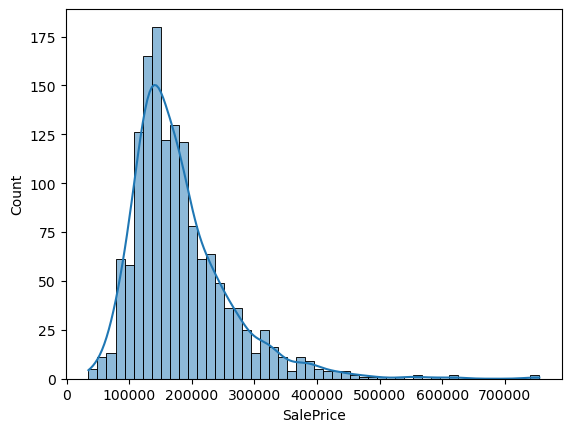

In [1571]:
sns.histplot(y_train, bins=50, kde=True)

### Numeric Variable Exploration

In [1572]:
list(set(X_train.dtypes.tolist()))

[CategoricalDtype(categories=['C (all)', 'FV', 'None', 'RH', 'RL', 'RM'], ordered=False),
 CategoricalDtype(categories=['2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort',
                   'Detchd', 'None'],
 , ordered=False),
 dtype('int64'),
 CategoricalDtype(categories=['BrkCmn', 'BrkFace', 'None', 'Stone'], ordered=False),
 CategoricalDtype(categories=['None', 'Sal', 'Sev', 'Maj1', 'Maj2', 'Mod', 'Min2', 'Min1',
                   'Typ'],
 , ordered=True),
 CategoricalDtype(categories=['COD', 'CWD', 'Con', 'ConLD', 'ConLI', 'ConLw', 'New',
                   'None', 'Oth', 'WD'],
 , ordered=False),
 CategoricalDtype(categories=['None', 'Unf', 'RFn', 'Fin'], ordered=True),
 CategoricalDtype(categories=['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr',
                   'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR',
                   'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes',
                   'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer',
             

In [1573]:
numeric_data = X_train.select_dtypes(include = ['float64', 'int64'])
numeric_data

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,SalePrice
0,65.0,8450,2003,2003,196.0,706.0,0.0,150.0,856.0,856,...,2003.0,2.0,548.0,0,61,0,0,0,0,208500.0
1,80.0,9600,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,...,1976.0,2.0,460.0,298,0,0,0,0,0,181500.0
2,68.0,11250,2001,2002,162.0,486.0,0.0,434.0,920.0,920,...,2001.0,2.0,608.0,0,42,0,0,0,0,223500.0
3,60.0,9550,1915,1970,0.0,216.0,0.0,540.0,756.0,961,...,1998.0,3.0,642.0,0,35,272,0,0,0,140000.0
4,84.0,14260,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,...,2000.0,3.0,836.0,192,84,0,0,0,0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,1999,2000,0.0,0.0,0.0,953.0,953.0,953,...,1999.0,2.0,460.0,0,40,0,0,0,0,175000.0
1456,85.0,13175,1978,1988,119.0,790.0,163.0,589.0,1542.0,2073,...,1978.0,2.0,500.0,349,0,0,0,0,0,210000.0
1457,66.0,9042,1941,2006,0.0,275.0,0.0,877.0,1152.0,1188,...,1941.0,1.0,252.0,0,60,0,0,0,0,266500.0
1458,68.0,9717,1950,1996,0.0,49.0,1029.0,0.0,1078.0,1078,...,1950.0,1.0,240.0,366,0,112,0,0,0,142125.0


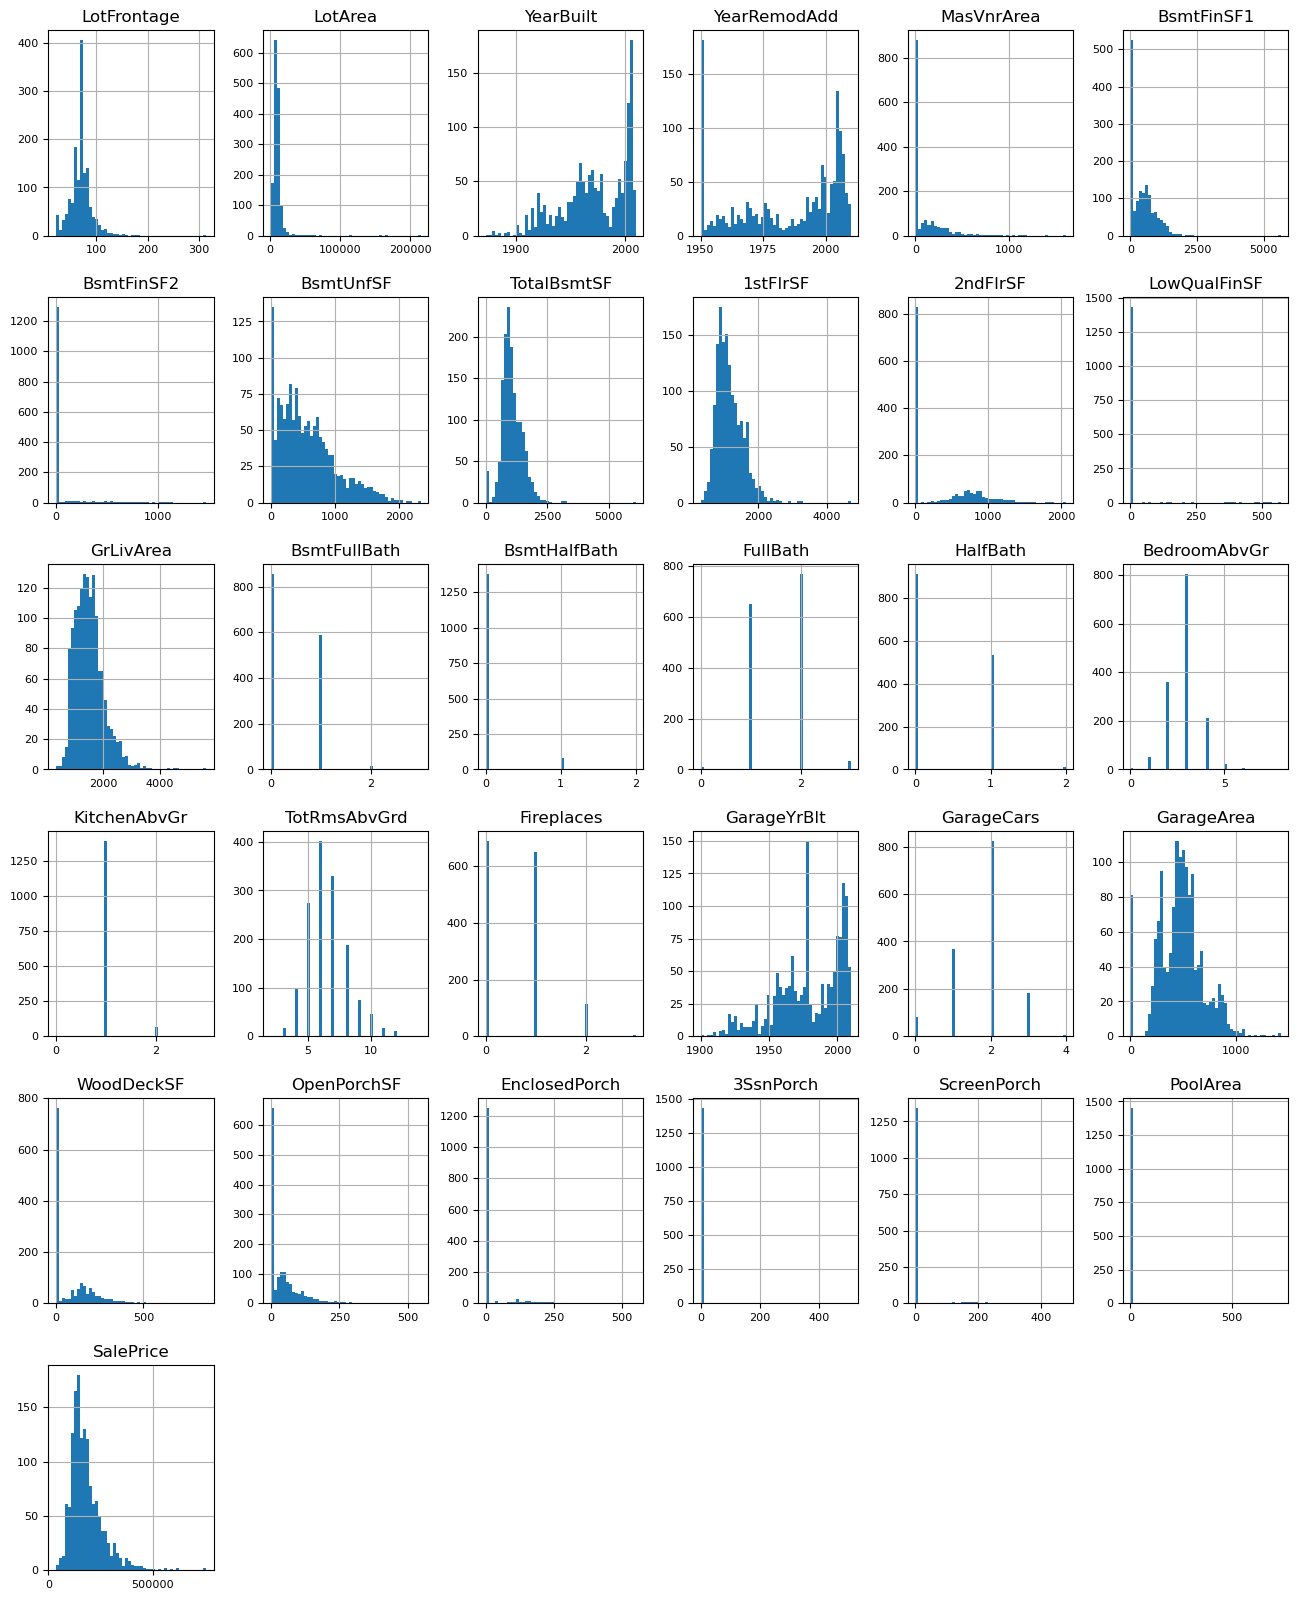

In [1574]:
numeric_data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

### Feature Engineering

In [1575]:
def transform(df):
    
    # sum up porch area
    df['PorchArea'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df = df.drop(columns=['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'])
    
    # convert garage constructed year into age
    today = datetime.date.today()
    df['GarageAge'] = today.year - df['GarageYrBlt']
    
    # calculating total bathroom count
    df['TotalBathrooms'] = df['FullBath'] + 0.5*df['HalfBath']
    df = df.drop(columns=['FullBath','HalfBath'])
    
    # performing log transformation of lot area
    df['LotArea_log'] = np.log(df['LotArea'])
    df = df.drop(columns=['LotArea'])
    
    # performing log transformation of lot frontage
    df['LotFrontage_log'] = np.log(df['LotFrontage'])
    df = df.drop(columns=['LotFrontage'])
    
    # calculating total sqft
    df['total_sqft'] = df['1stFlrSF'] + df['2ndFlrSF']
    df['total_sqft']
    
    # turning 2ndFlr into boolean
    df['2ndFlr'] = np.where(df['2ndFlrSF'] > 0, 1, 0)
    df = df.drop(columns=['1stFlrSF', '2ndFlrSF'])
    
    # calculating total basement bathroom count
    df['BsmtBathrooms'] = df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df = df.drop(columns=['BsmtFullBath','BsmtHalfBath'])
    
    return df

X_train = transform(X_train)
X_test = transform(X_test)
merged_data = transform(merged_data)
X_train

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,SaleCondition,SalePrice,PorchArea,GarageAge,TotalBathrooms,LotArea_log,LotFrontage_log,total_sqft,2ndFlr,BsmtBathrooms
0,60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,Normal,208500.0,61,21.0,2.5,9.041922,4.174387,1710,1,1.0
1,20,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,Normal,181500.0,298,48.0,2.0,9.169518,4.382027,1262,0,0.5
2,60,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,Normal,223500.0,42,23.0,2.5,9.328123,4.219508,1786,1,1.0
3,70,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,Abnorml,140000.0,307,26.0,1.0,9.164296,4.094345,1717,1,1.0
4,60,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,Normal,250000.0,276,24.0,2.5,9.565214,4.430817,2198,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,Normal,175000.0,40,25.0,2.5,8.976768,4.127134,1647,1,0.0
1456,20,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,Normal,210000.0,349,46.0,2.0,9.486076,4.442651,2073,0,1.0
1457,70,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,Normal,266500.0,60,83.0,2.0,9.109636,4.189655,2340,1,0.0
1458,20,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,Normal,142125.0,478,74.0,1.0,9.181632,4.219508,1078,0,1.0


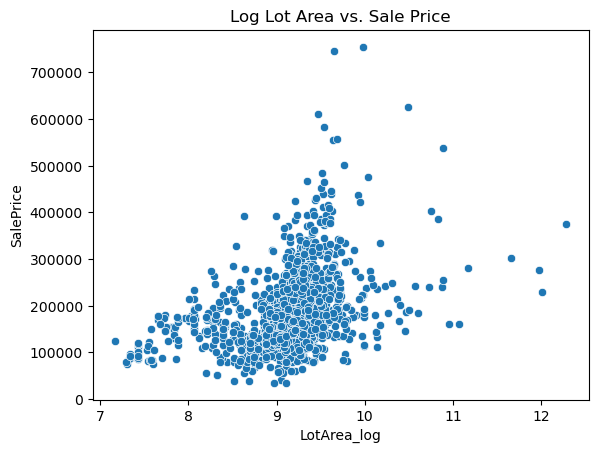

In [1576]:
sns.scatterplot(x='LotArea_log', y='SalePrice', data=X_train)
plt.title('Log Lot Area vs. Sale Price')
plt.show()

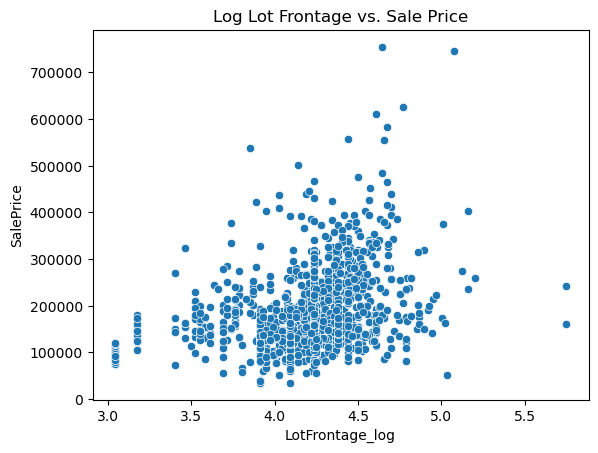

In [1577]:
sns.scatterplot(x='LotFrontage_log', y='SalePrice', data=X_train)
plt.title('Log Lot Frontage vs. Sale Price')
plt.show()

### Categorical Variable Exploration

In [1578]:
X_categorical = X_train.select_dtypes(include = ['category', 'O'])
X_categorical.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

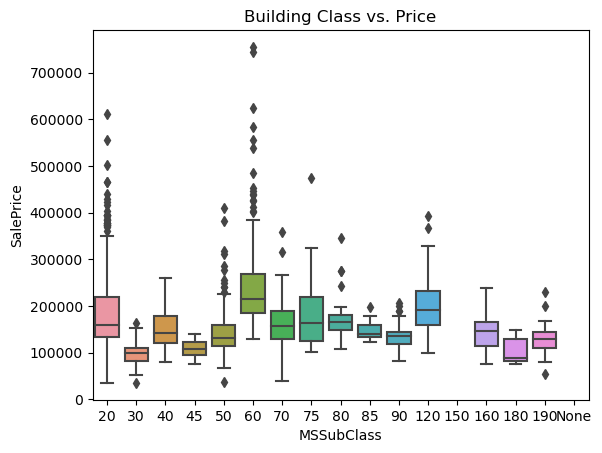

In [1579]:
"""Visualizing building class by price"""
sns.boxplot(x='MSSubClass', y='SalePrice', data=X_train)
plt.title('Building Class vs. Price')
plt.show()

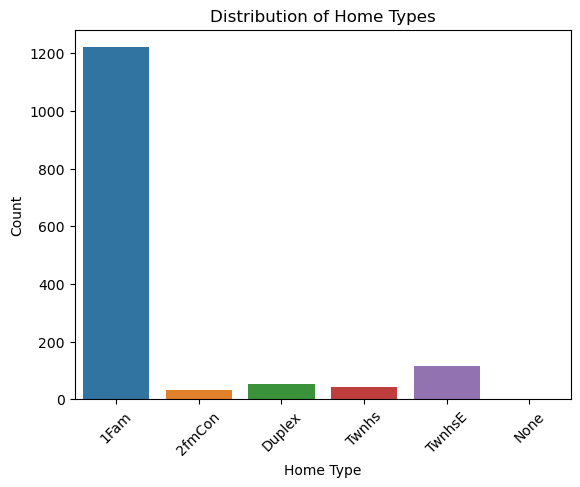

In [1580]:
""" Visualize the distribution of building types """
sns.countplot(data=X_train, x='BldgType')
plt.title('Distribution of Home Types')
plt.xlabel('Home Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

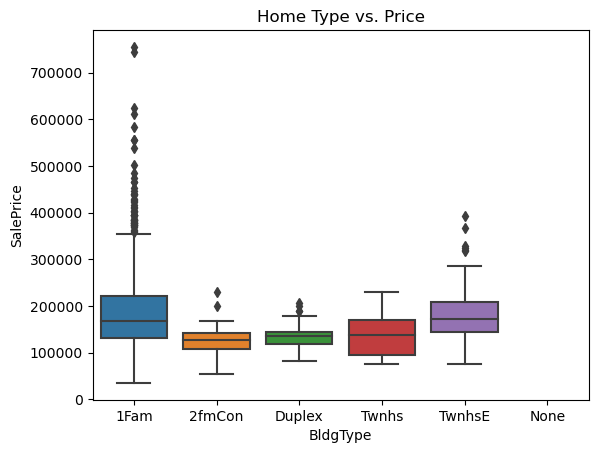

In [1581]:
"""Visualizing home type by price"""
sns.boxplot(x='BldgType', y='SalePrice', data=X_train)
plt.title('Home Type vs. Price')
plt.show()

/var/folders/sw/6pmb_by53cx1hvn3p_xkx44m0000gn/T/ipykernel_92204/1955796612.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X_train.corr()


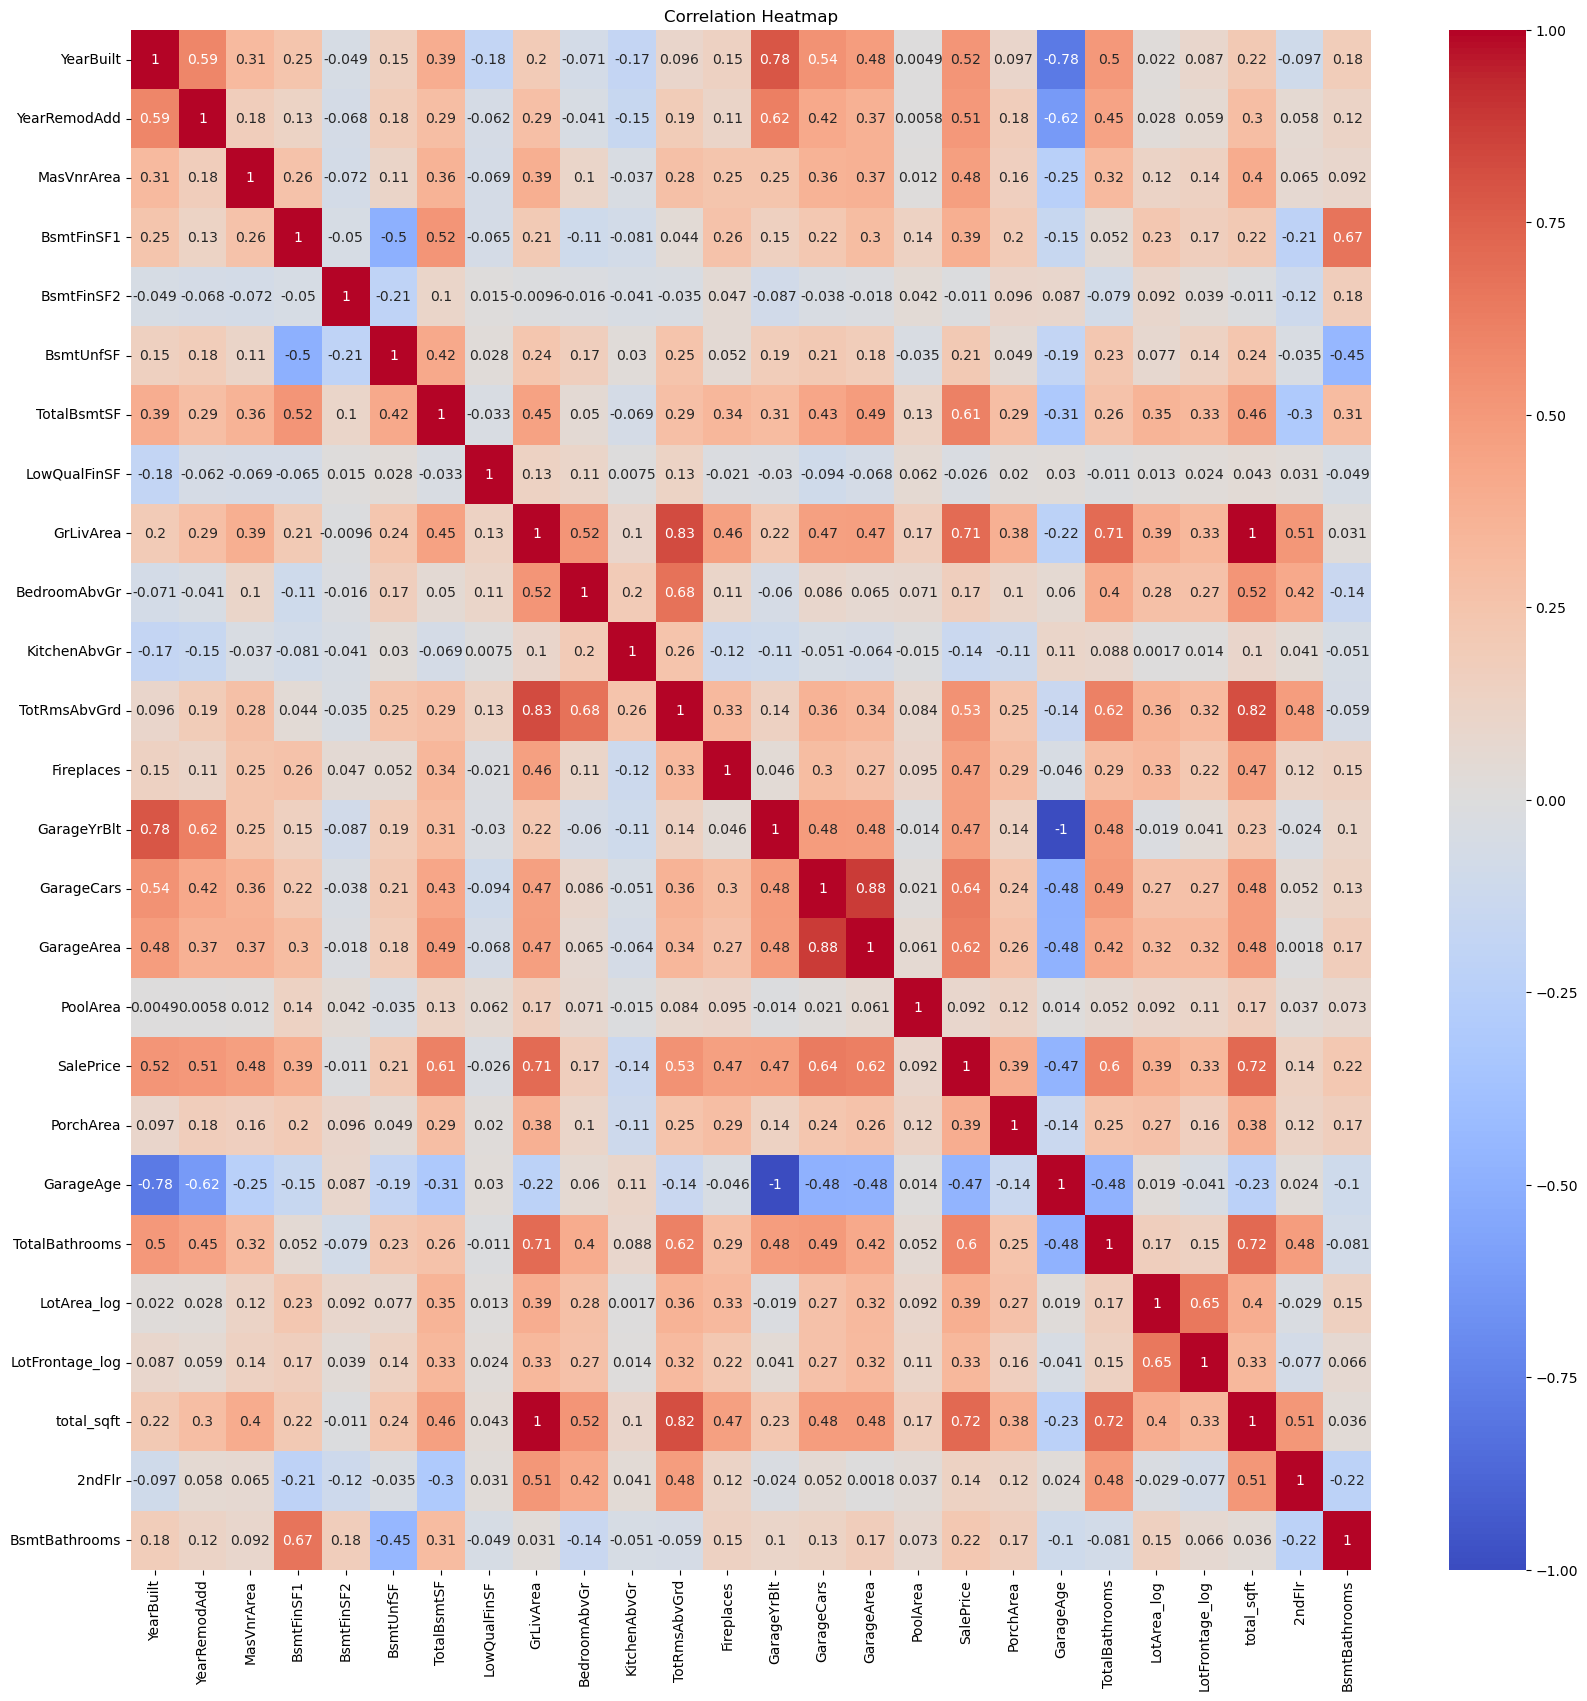

In [1582]:
"""Multivariate analysis"""

corr_matrix = X_train.corr()
plt.figure(figsize=(20,20))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

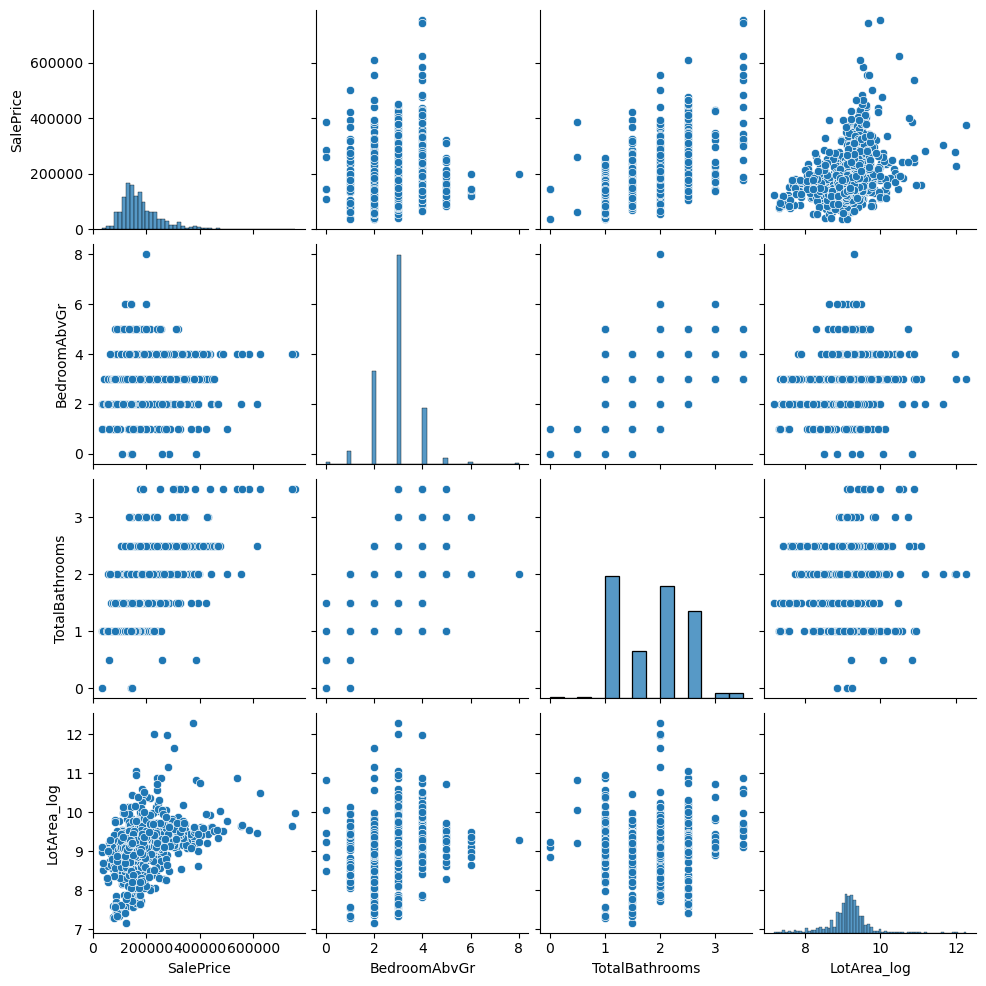

In [1583]:
# viewing relationship between a few key categorical vars
selected_vars = ['SalePrice', 'BedroomAbvGr', 'TotalBathrooms', 'LotArea_log']
sns.pairplot(X_train[selected_vars])
plt.show()

In [1584]:
baseline_score = score_dataset(X_train, y_train)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

/var/folders/sw/6pmb_by53cx1hvn3p_xkx44m0000gn/T/ipykernel_92204/2330612796.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_copy.loc[:, colname] = X_copy[colname].cat.codes


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 1588, in _init
    it.reraise()
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 576, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 557, in _handle_exception
    return fn()
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 641, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/data.py", line 1280, in next
    input_data(**self.kwargs)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/core.py", line 624, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/data.py", line 1315, in _proxy_transform
    arr, feature_names, feature_types = _transform_pandas_df(
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/data.py", line 490, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "/Users/phoelandsiu/anaconda3/lib/python3.10/site-packages/xgboost/data.py", line 308, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:MSSubClass: category, MSZoning: category, Street: category, Alley: category, LotShape: category, LandContour: category, Utilities: category, LotConfig: category, LandSlope: category, Neighborhood: category, Condition1: category, Condition2: category, BldgType: category, HouseStyle: category, OverallQual: category, OverallCond: category, RoofStyle: category, RoofMatl: category, Exterior1st: category, Exterior2nd: category, MasVnrType: category, ExterQual: category, ExterCond: category, Foundation: category, BsmtQual: category, BsmtCond: category, BsmtExposure: category, BsmtFinType1: category, BsmtFinType2: category, Heating: category, HeatingQC: category, CentralAir: category, Electrical: category, KitchenQual: category, Functional: category, FireplaceQu: category, GarageType: category, GarageFinish: category, GarageQual: category, GarageCond: category, PavedDrive: category, Fence: category, MiscFeature: category, SaleType: category, SaleCondition: category


## Target Encoding

Implement a practice called mean encoding, which encodes the mean of the target variable binned by each categorical feature.

In [1585]:
categorical_features = X_train.select_dtypes(include = ['category', 'O']).columns.to_list()[:-1]
selected_features = categorical_features + ['SalePrice']

X_encoding = X_train[selected_features]
X_encoding

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,SaleType,SalePrice
0,60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,None,Attchd,RFn,TA,TA,Y,None,None,WD,208500.0
1,20,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,TA,Attchd,RFn,TA,TA,Y,None,None,WD,181500.0
2,60,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,Attchd,RFn,TA,TA,Y,None,None,WD,223500.0
3,70,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,Gd,Detchd,Unf,TA,TA,Y,None,None,WD,140000.0
4,60,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,TA,Attchd,RFn,TA,TA,Y,None,None,WD,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,TA,Attchd,RFn,TA,TA,Y,None,None,WD,175000.0
1456,20,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,TA,Attchd,Unf,TA,TA,Y,MnPrv,None,WD,210000.0
1457,70,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,Gd,Attchd,RFn,TA,TA,Y,GdPrv,Shed,WD,266500.0
1458,20,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,None,Attchd,Unf,TA,TA,Y,None,None,WD,142125.0


In [1586]:
def encode_categoricals(df):
    
    for i in categorical_features: 
        df[i + '_encoded'] = df.groupby(i)["SalePrice"].transform("mean")
        df = df.drop(columns=[i])
    return df

# perform encoding on the merged_data df so that we can encode the categoricals in the test set with the target values
merged_data = encode_categoricals(merged_data)

In [1587]:
merged_data.isnull().sum()[lambda x: x > 0]

SalePrice              1459
MSSubClass_encoded        1
MSZoning_encoded          4
Utilities_encoded         2
OverallQual_encoded      31
Exterior1st_encoded       1
Exterior2nd_encoded       1
KitchenQual_encoded       1
Functional_encoded        2
SaleType_encoded          1
dtype: int64

In [1588]:
impute(merged_data)

,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,GrLivArea,BedroomAbvGr,...,Functional_encoded,FireplaceQu_encoded,GarageType_encoded,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,Fence_encoded,MiscFeature_encoded,SaleType_encoded
0,1961,1961,0.0,468.0,144.0,270.0,882.0,0,896,2,...,183429.147059,141331.482609,202892.656322,142156.423140,187489.836003,187885.735294,186433.973881,148751.089172,182046.410384,173401.836622
1,1958,1958,108.0,923.0,0.0,406.0,1329.0,0,1329,3,...,183429.147059,141331.482609,202892.656322,142156.423140,187489.836003,187885.735294,186433.973881,187596.837998,170750.000000,173401.836622
2,1997,1998,0.0,791.0,0.0,137.0,928.0,0,1629,3,...,183429.147059,205723.488818,202892.656322,240052.690341,187489.836003,187885.735294,186433.973881,148751.089172,182046.410384,173401.836622
3,1998,1998,20.0,602.0,0.0,324.0,926.0,0,1604,3,...,183429.147059,226351.415789,202892.656322,240052.690341,187489.836003,187885.735294,186433.973881,187596.837998,182046.410384,173401.836622
4,1992,1992,0.0,263.0,0.0,1017.0,1280.0,0,1280,2,...,183429.147059,141331.482609,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,187596.837998,182046.410384,173401.836622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1999,2000,0.0,0.0,0.0,953.0,953.0,0,1647,3,...,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,187596.837998,182046.410384,173401.836622
1456,1978,1988,119.0,790.0,163.0,589.0,1542.0,0,2073,3,...,146385.483871,205723.488818,202892.656322,142156.423140,187489.836003,187885.735294,186433.973881,148751.089172,182046.410384,173401.836622
1457,1941,2006,0.0,275.0,0.0,877.0,1152.0,0,2340,4,...,183429.147059,226351.415789,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,178927.457627,151187.612245,173401.836622
1458,1950,1996,0.0,49.0,1029.0,0.0,1078.0,0,1078,2,...,183429.147059,141331.482609,202892.656322,142156.423140,187489.836003,187885.735294,186433.973881,187596.837998,182046.410384,173401.836622


In [1589]:
X_train = merged_data[merged_data['ind']=='train'].drop(columns=['ind'])
X_test = merged_data[merged_data['ind']=='test'].drop(columns=['SalePrice','ind'])

In [1590]:
[i for i in X_train.columns.to_list() if i not in X_test.columns.to_list()]

['SalePrice']

In [1591]:
X_train.columns

Index(['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'PoolArea', 'SaleCondition', 'SalePrice',
       'PorchArea', 'GarageAge', 'TotalBathrooms', 'LotArea_log',
       'LotFrontage_log', 'total_sqft', '2ndFlr', 'BsmtBathrooms',
       'MSSubClass_encoded', 'MSZoning_encoded', 'Street_encoded',
       'Alley_encoded', 'LotShape_encoded', 'LandContour_encoded',
       'Utilities_encoded', 'LotConfig_encoded', 'LandSlope_encoded',
       'Neighborhood_encoded', 'Condition1_encoded', 'Condition2_encoded',
       'BldgType_encoded', 'HouseStyle_encoded', 'OverallQual_encoded',
       'OverallCond_encoded', 'RoofStyle_encoded', 'RoofMatl_encoded',
       'Exterior1st_encoded', 'Exterior2nd_encoded', 'MasVnrType_encoded',
       'ExterQual_encoded', 'ExterCond_encoded', 'Foundation_encode

## PCA

In [1592]:
def implement_pca(data, feature_names=None):
    
    # first step is to standardize the data
    data_standardized = (data - data.mean(axis=0)) / data.std(axis=0)
    
    # apply PCA
    pca = PCA()
    data_pca = pca.fit_transform(data)
    
    # adopted from https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
    component_names = [f"PC{i+1}" for i in range(data_pca.shape[1])]
    data_pca = pd.DataFrame(data_pca, columns=component_names)
    
    # return number of principle components
    n = pca.n_components_
    
    # return explained variance ratio for each feature
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # return names of features to be maintained
    if feature_names is not None:
        pca_features = feature_names
    else:
        pca_features = list(data.columns)

    return n, data_pca, pca_features, explained_variance_ratio

numeric_datset = X_train.select_dtypes(include = ['float64', 'int64']).drop(columns=['SalePrice'])

pca_results = implement_pca(numeric_datset)
pca_results

(69,
                 PC1           PC2           PC3           PC4           PC5  \
 0     107203.080060 -14193.205765 -74753.240367  13868.846656 -31701.106540   
 1      -2155.943906 -42389.210129  44858.812251 -66673.407199  33222.591243   
 2     122323.017089 -21682.790545 -37050.482836  13801.530869  -3975.370279   
 3     -27662.654686  17704.416264  86170.688572  -9301.928509 -37794.489970   
 4     199996.294231 -11546.726518   9773.701804 -70127.826810 -62799.026237   
 ...             ...           ...           ...           ...           ...   
 1455   27857.082390 -80036.063950 -48559.343015 -17638.538753 -18008.551988   
 1456  -34740.502972 -27683.234092  44941.323521 -38377.355347  18836.337505   
 1457  126362.095219  31921.552351  -5641.674079  80967.968042 -43252.203588   
 1458  -74436.339364  -2397.064310   3104.630410  12653.630290  12439.083555   
 1459  -60470.478856 -53610.851938  -8423.057622  51969.557814   -839.863878   
 
                PC6           PC7

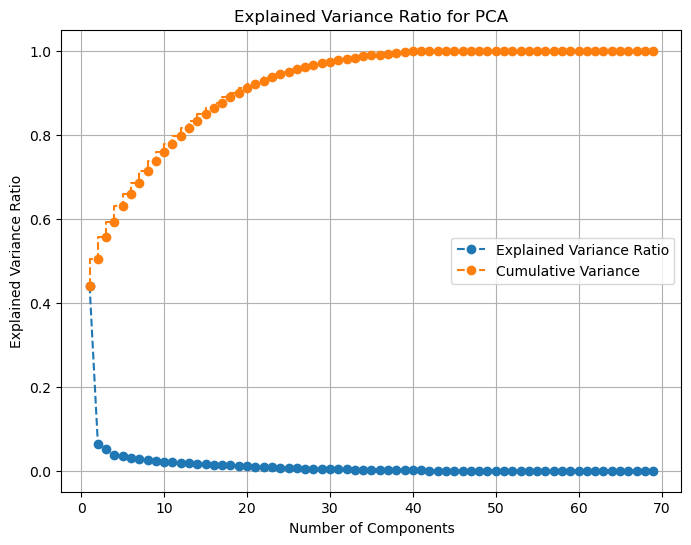

In [1593]:
def plot_pca(data, explained_variance):
    
    num_components = len(explained_variance)

    plt.figure(figsize=(8, 6)) 

    plt.plot(range(1, num_components + 1), explained_variance, marker='o', linestyle='--', label='Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')

    plt.step(range(1, num_components + 1), explained_variance.cumsum(), marker='o', linestyle='--', label='Cumulative Variance')

    plt.title('Explained Variance Ratio for PCA')
    plt.grid(True)
    plt.legend()

    plt.show()
    
plot_pca(pca_results[1], pca_results[3])

**Look at mi scores of principal components to verify that they are high**

In [1594]:
final_y_train = X_train.pop('SalePrice')

In [1595]:
mi_scores = make_mi_scores(pca_results[1], y)
mi_scores

PC1     0.761956
PC27    0.223793
PC41    0.151945
PC2     0.150408
PC29    0.147935
          ...   
PC44    0.010468
PC37    0.009212
PC61    0.001373
PC51    0.000000
PC69    0.000000
Name: MI Scores, Length: 69, dtype: float64

Even though mi_scores aren't high for the bottom few features, we can assume that they still eliminate some variance within the data and therefore are still relevant.

**Making final dataset based on PCA exploration**

In [1596]:
final_train_dataset = X_train[pca_results[2]]
final_test_dataset = X_test[pca_results[2]]
final_train_dataset

,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,GrLivArea,BedroomAbvGr,...,Functional_encoded,FireplaceQu_encoded,GarageType_encoded,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,Fence_encoded,MiscFeature_encoded,SaleType_encoded
0,2003,2003,196.0,706.0,0.0,150.0,856.0,0,1710,3,...,183429.147059,141331.482609,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,187596.837998,182046.410384,173401.836622
1,1976,1976,0.0,978.0,0.0,284.0,1262.0,0,1262,3,...,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,187596.837998,182046.410384,173401.836622
2,2001,2002,162.0,486.0,0.0,434.0,920.0,0,1786,3,...,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,187596.837998,182046.410384,173401.836622
3,1915,1970,0.0,216.0,0.0,540.0,756.0,0,1717,3,...,183429.147059,226351.415789,134091.162791,142156.423140,187489.836003,187885.735294,186433.973881,187596.837998,182046.410384,173401.836622
4,2000,2000,350.0,655.0,0.0,490.0,1145.0,0,2198,4,...,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,187596.837998,182046.410384,173401.836622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1999,2000,0.0,0.0,0.0,953.0,953.0,0,1647,3,...,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,187596.837998,182046.410384,173401.836622
1456,1978,1988,119.0,790.0,163.0,589.0,1542.0,0,2073,3,...,146385.483871,205723.488818,202892.656322,142156.423140,187489.836003,187885.735294,186433.973881,148751.089172,182046.410384,173401.836622
1457,1941,2006,0.0,275.0,0.0,877.0,1152.0,0,2340,4,...,183429.147059,226351.415789,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,178927.457627,151187.612245,173401.836622
1458,1950,1996,0.0,49.0,1029.0,0.0,1078.0,0,1078,2,...,183429.147059,141331.482609,202892.656322,142156.423140,187489.836003,187885.735294,186433.973881,187596.837998,182046.410384,173401.836622


**NOTE: DO THE SAME TO THE TEST DATASET**

### Model Training

In [1597]:
model = XGBRegressor()
model.fit(final_train_dataset, np.log(final_y_train))

predictions = np.exp(model.predict(final_test_dataset))
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})

In [1600]:
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
